In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict, namedtuple
import itertools
import typing


import numpy as np
import matplotlib
import matplotlib.axes
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
import colorcet as cc
import cv2
import pandas as pd

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import tabulate


from simple_relational_reasoning.embeddings.stimuli import PatchStimulusGenerator, build_differet_shapes_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION
from simple_relational_reasoning.embeddings.visualizations import save_plot


In [2]:
def default_name_func(generator_kwargs, base_name=''):
    two_reference_objects = generator_kwargs['two_reference_objects']
    transpose = generator_kwargs['transpose']
    
    if two_reference_objects:
        if transpose:
            rel_name = 'VerticalBetween'
        else:
            rel_name = 'Between'
    else:
        if transpose:
            rel_name = 'Left/Right'
        else:
            rel_name = 'Above/Below'
    
    name = f'{base_name}{base_name and "-" or ""}{rel_name}'
            
    n_target_types = None
    if 'n_target_types' in generator_kwargs:
        n_target_types = generator_kwargs['n_target_types']
        return name + f'-{n_target_types}-types'
    
    return name

def create_generators_and_names(triplet_generator_class, stimulus_generator, kwarg_value_sets, 
                                name_func=default_name_func, name_func_kwargs=None):
    if name_func_kwargs is None:
        name_func_kwargs = {}
    
    names = []
    triplet_generators = []

    for value_set in itertools.product(*kwarg_value_sets.values()):
        kwargs = {k: v for (k, v) in zip(kwarg_value_sets.keys(), value_set)}

        if 'relation' in kwargs and kwargs['relation'] == BETWEEN_RELATION:
            kwargs['two_reference_objects'] = True

        names.append(name_func(kwargs, **name_func_kwargs))
        triplet_generators.append(triplet_generator_class(stimulus_generator, **kwargs))

    return names, triplet_generators

In [3]:
QUINN_DISTANCE_ENDPOINTS = (30, 70)

quinn_default_value_sets = dict(
    relation=(ABOVE_BELOW_RELATION, BETWEEN_RELATION),
    distance_endpoints=(QUINN_DISTANCE_ENDPOINTS,),
    two_reference_objects=(False,),
    transpose=(False,),
    n_target_types=(1, 2),
)

RANDOM_SEED = 33
RNG = np.random.default_rng(RANDOM_SEED)

split_text_gen = build_split_text_stimulus_generator(rng=RNG)
quinn_split_reference_text_names, quinn_split_reference_text_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_text_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference-Text'))


random_colors_gen = build_random_color_stimulus_generator(rng=RNG)
quinn_random_colors_names, quinn_random_colors_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, random_colors_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Random-Colors'))


different_shapes_gen = build_differet_shapes_stimulus_generator(rng=RNG)
quinn_different_shapes_names, quinn_different_shapes_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, different_shapes_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Different-Shapes'))

In [4]:
TRIPLET_AX_INDICES = ((0, 1), (1, 0), (1, 2))
IGNORE_AX_INDICES = ((0, 0), (0, 2), (1, 1))
TITLES = ('Familiarization', 'Same Relation', 'Other Relation')

def plot_stimuli_triplet(triplet: torch.Tensor, 
    axes: typing.Optional[typing.List[typing.List[matplotlib.axes.Axes]]] = None, 
    title: typing.Optional[str] = None, y_label: typing.Optional[str] = None,
    x_label: typing.Optional[str] = None,
    figsize: typing.Tuple[int, int] = (8, 6), 
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    left_adjustment: float = 0, bottom_adjustment: float = 0, 
    right_adjustment: float = 0, top_adjustment: float = 0,
    fontsize: int = 16, titles: typing.Sequence[str] = TITLES,
    save_path: typing.Optional[str] = None):

    if axes is None:
        fig, axes = plt.subplots(2, 3, figsize=figsize)

    if subplots_adjust_params is None:
        subplots_adjust_params = {}

    plot_axes = []

    for i, (ax_row, ax_col) in enumerate(TRIPLET_AX_INDICES):
        ax = axes[ax_row][ax_col]
        ax.imshow(triplet[i].permute(1, 2, 0).numpy())
        ax.set_title(titles[i], fontsize=fontsize)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plot_axes.append(ax)

    for ax_row, ax_col in IGNORE_AX_INDICES:
        ax = axes[ax_row][ax_col]
        ax.axis('off')

    plt.subplots_adjust(**subplots_adjust_params)

    x0 = min([ax.get_position().x0 for ax in plot_axes])
    y0 = min([ax.get_position().y0 for ax in plot_axes])
    x1 = max([ax.get_position().x1 for ax in plot_axes])
    y1 = max([ax.get_position().y1 for ax in plot_axes])
    # Hidden axes for common x and y labels
    plt.axes([x0 + left_adjustment, y0 + bottom_adjustment, x1 - x0 + right_adjustment, y1 - y0 + top_adjustment], frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    # Labelize
    if x_label: plt.xlabel(x_label, fontsize=fontsize + 4, fontweight='bold')
    if y_label: plt.ylabel(y_label, fontsize=fontsize + 4, fontweight='bold', labelpad=-10)
    if title: plt.title(title, fontsize=fontsize + 4, fontweight='bold')

    if save_path is not None:
        save_plot(save_path)

    plt.show()

    


## Basic form for the introduction

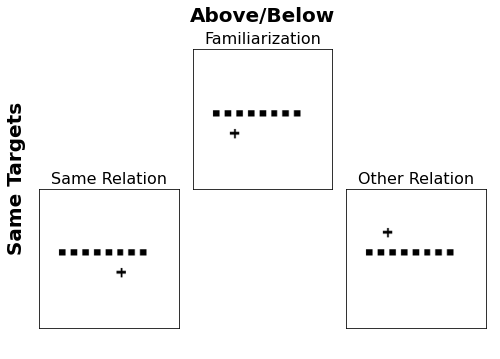

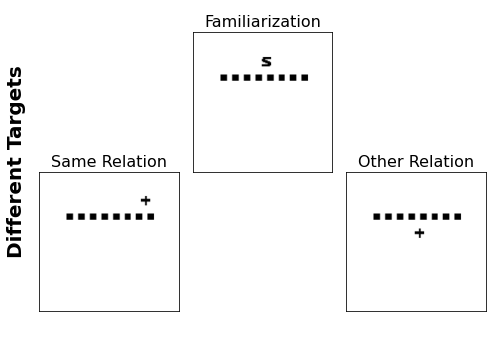

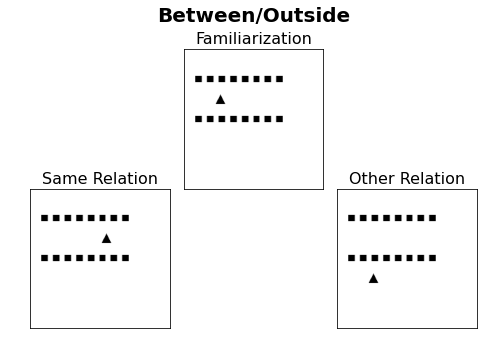

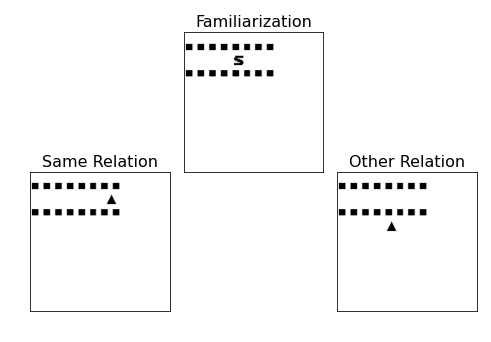

In [5]:
relation_names = ['Above/Below', 'Between/Outside']
target_type_names = ['Same Targets', 'Different Targets']


for i, trip_gen in enumerate(quinn_split_reference_text_triplet_generators):
    triplet = trip_gen(i + 1, normalize=False)[i]
    plot_stimuli_triplet(triplet, title=f'{relation_names[i // 2]}' if i % 2 == 0 else None,   # title=f'{relation_names[i // 2]} {target_type_names[i % 2]}', 
        subplots_adjust_params=dict(hspace=-.25, wspace=0.1), top_adjustment=0.05,
        y_label=target_type_names[i % 2] if i // 2 == 0 else None,
        save_path=f'paper/intro/intro_example_{i}.pdf')

## Alternative generators for the appendix of the experiment 1 description

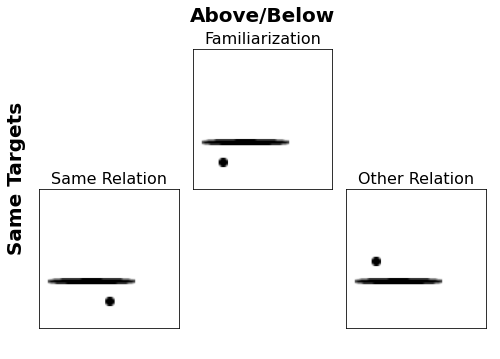

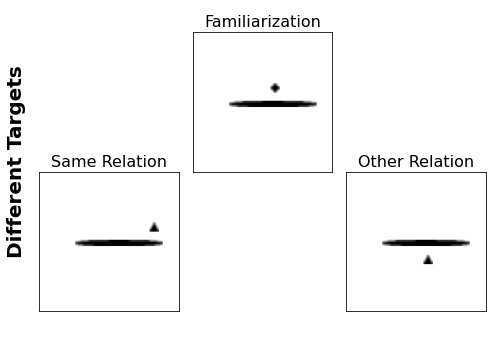

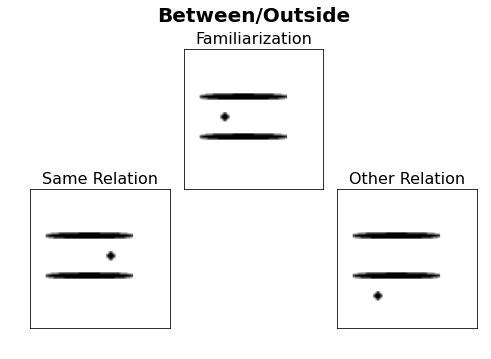

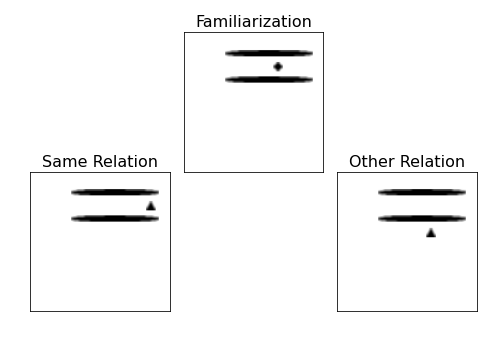

In [6]:
for i, trip_gen in enumerate(quinn_different_shapes_triplet_generators):
    triplet = trip_gen(i + 1, normalize=False)[i]
    plot_stimuli_triplet(triplet, title=f'{relation_names[i // 2]}' if i % 2 == 0 else None,   # title=f'{relation_names[i // 2]} {target_type_names[i % 2]}', 
        subplots_adjust_params=dict(hspace=-.25, wspace=0.1), top_adjustment=0.05,
        y_label=target_type_names[i % 2] if i // 2 == 0 else None,
        save_path=f'paper/appendix/stimuli/shapes_example_{i}.pdf')

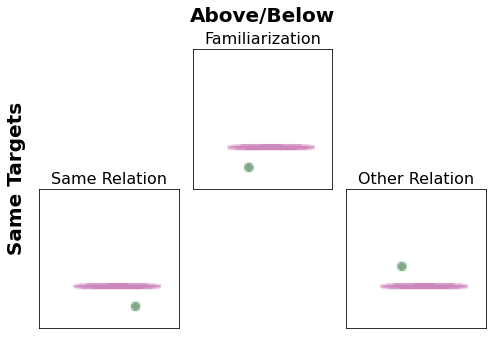

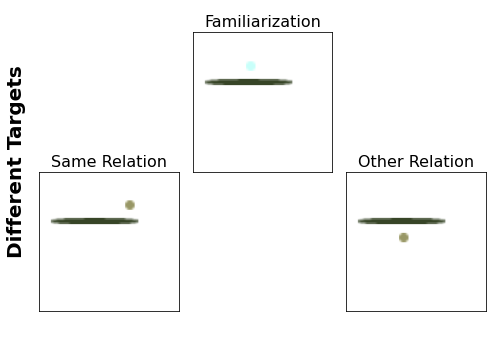

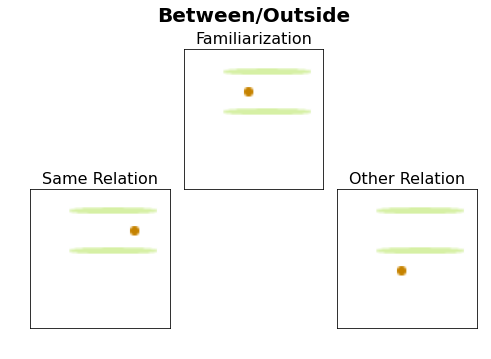

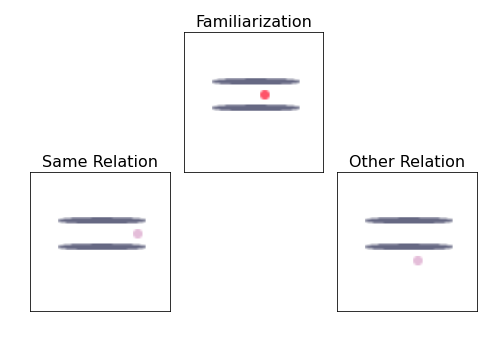

In [7]:
for i, trip_gen in enumerate(quinn_random_colors_triplet_generators):
    triplet = trip_gen(i + 1, normalize=False)[i]
    plot_stimuli_triplet(triplet, title=f'{relation_names[i // 2]}' if i % 2 == 0 else None,   # title=f'{relation_names[i // 2]} {target_type_names[i % 2]}', 
        subplots_adjust_params=dict(hspace=-.25, wspace=0.1), top_adjustment=0.05,
        y_label=target_type_names[i % 2] if i // 2 == 0 else None,
        save_path=f'paper/appendix/stimuli/colors_example_{i}.pdf')

## Alternative above/below methods for the appendix

In [8]:
quinn_above_below_variant_value_sets = dict(
    relation=(ABOVE_BELOW_RELATION,),
    distance_endpoints=((50, 100),),
    two_reference_objects=(True,),
    adjacent_reference_objects=(True, False,),
    transpose=(False,),
    n_target_types=(1, 2),
)

RANDOM_SEED = 33
RNG = np.random.default_rng(RANDOM_SEED)

_, above_below_variant_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_text_gen, quinn_above_below_variant_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference-Text'))

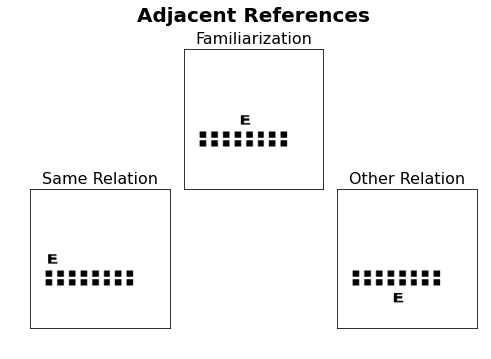

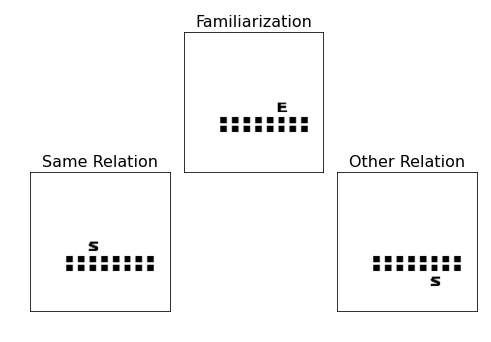

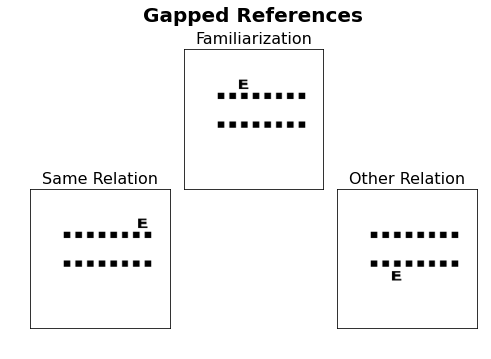

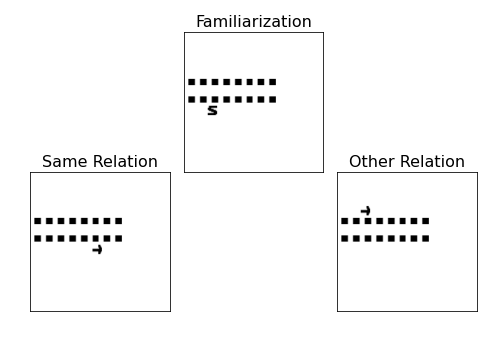

In [9]:
offset = 3
above_below_variant_names = ['Adjacent References', 'Gapped References']

for i, trip_gen in enumerate(above_below_variant_triplet_generators):
    triplet = trip_gen(offset + i + 1, normalize=False)[offset + i]
    title = f'{above_below_variant_names[i // 2]}'
    plot_stimuli_triplet(triplet, title=title if i % 2 == 0 else None,   # title=f'{relation_names[i // 2]} {target_type_names[i % 2]}', 
        subplots_adjust_params=dict(hspace=-.25, wspace=0.1), top_adjustment=0.05,
        # y_label=target_type_names[i % 2] if i // 2 == 0 else None,
        save_path=f'paper/appendix/stimuli/{"_".join(title.lower().split(" "))}_variant_example_{i % 2}.pdf',
        )

## Rotated angles for experiment 1c

In [10]:
ROTATE_ANGLE = 90
QUINN_DISTANCE_ENDPOINTS = (30, 70)

quinn_default_value_sets = dict(
    relation=(ABOVE_BELOW_RELATION, BETWEEN_RELATION),
    distance_endpoints=(QUINN_DISTANCE_ENDPOINTS,),
    two_reference_objects=(False,),
    transpose=(False,),
    n_target_types=(1, 2),
)

RANDOM_SEED = 33
RNG = np.random.default_rng(RANDOM_SEED)

split_text_gen = build_split_text_stimulus_generator(rng=RNG, rotate_angle=ROTATE_ANGLE)
quinn_split_reference_text_names, quinn_split_reference_text_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_text_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference-Text'))


random_colors_gen = build_random_color_stimulus_generator(rng=RNG, rotate_angle=ROTATE_ANGLE)
quinn_random_colors_names, quinn_random_colors_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, random_colors_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Random-Colors'))


different_shapes_gen = build_differet_shapes_stimulus_generator(rng=RNG, rotate_angle=ROTATE_ANGLE)
quinn_different_shapes_names, quinn_different_shapes_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, different_shapes_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Different-Shapes'))

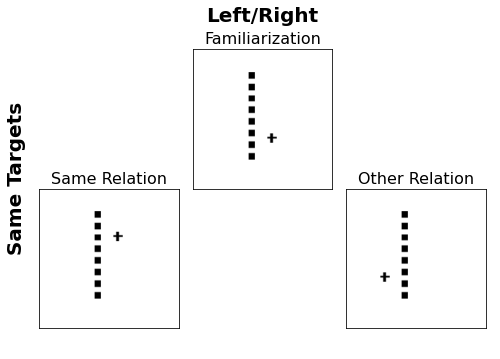

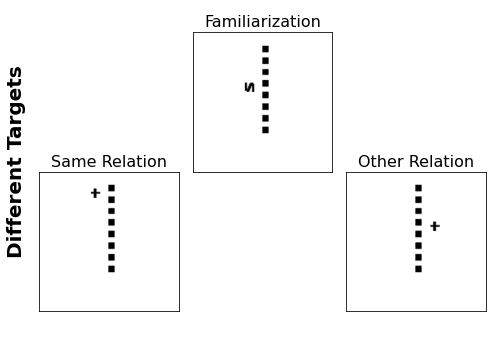

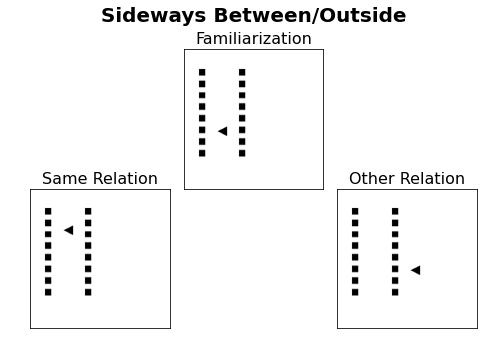

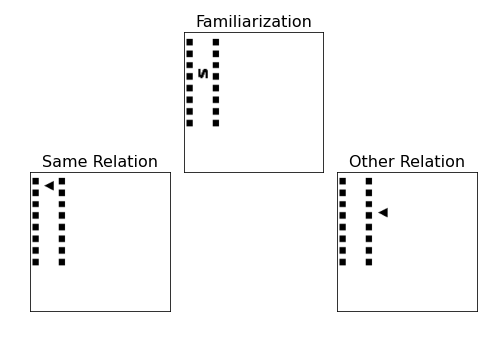

In [11]:
relation_names = ['Left/Right', 'Sideways Between/Outside']
target_type_names = ['Same Targets', 'Different Targets']


for i, trip_gen in enumerate(quinn_split_reference_text_triplet_generators):
    triplet = trip_gen(i + 1, normalize=False)[i]
    plot_stimuli_triplet(triplet, title=f'{relation_names[i // 2]}' if i % 2 == 0 else None,   # title=f'{relation_names[i // 2]} {target_type_names[i % 2]}', 
        subplots_adjust_params=dict(hspace=-.25, wspace=0.1), top_adjustment=0.05,
        y_label=target_type_names[i % 2] if i // 2 == 0 else None,
        save_path=f'paper/exp1/1c/example_stimuli_{i}.pdf')

## All rotated angles for experiment 1d

In [15]:
from torchvision.transforms import functional as F


FLIPS = (
    lambda x: x,
    F.hflip,
    F.vflip,
    # lambda x: F.hflip(F.vflip(x))
)

FLIP_NAMES = ('Neither', 'Horizontal', 'Vertical')  # , 'Both')


def plot_flipped_versions(base_images, base_image_names, save_path=None,
    flips=FLIPS, flip_names=FLIP_NAMES, text_kwargs=None):

    if text_kwargs is None:
        text_kwargs = {}
    
    k = len(base_images)
    n = len(flips)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            ax.imshow(flips[row](base_images[col]).permute(1, 2, 0).numpy())

            if row == 0:
                ax.set_title(base_image_names[col], **text_kwargs)

            if col == 0:
                ax.set_ylabel(flip_names[row], **text_kwargs)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path)

    plt.show()

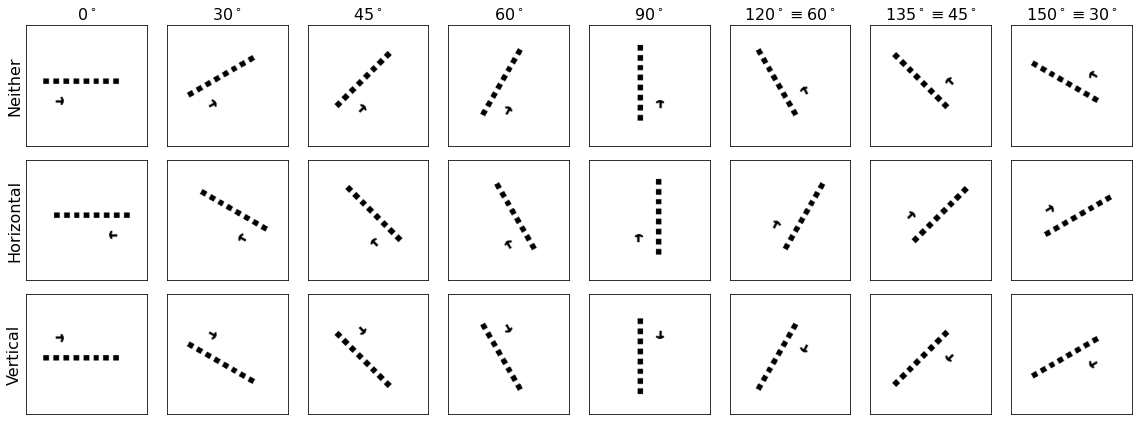

In [27]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 1
seed = 33
rotate_angles = [0, 30, 45, 60, 90, 120, 135, 150]

images = []

for rotate_angle in rotate_angles:
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))
    stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=rotate_angle)

    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=False, transpose=False,
        adjacent_reference_objects=False, n_target_types=2)

    triplets = triplet_generator(N_examples, normalize=False)
    images.append(triplets[0][0])

headings = [f'${angle}^\\circ$' if angle <= 90 else f'${angle}^\\circ \\equiv {180 - angle}^\\circ$' for angle in rotate_angles]

plot_flipped_versions(images, headings,
    save_path='paper/appendix/exp1/1d/rotate_angle_one_reference.pdf',
    text_kwargs=dict(fontsize=16))

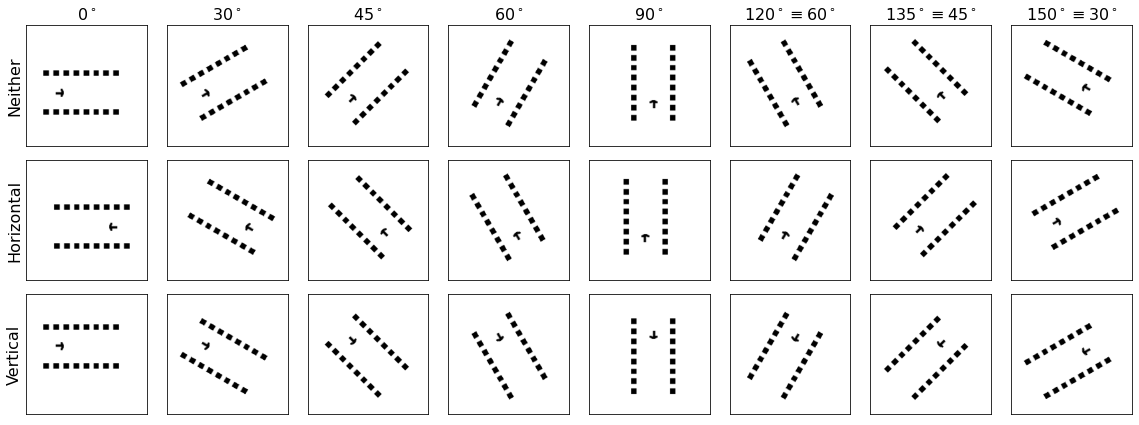

In [28]:
relation = BETWEEN_RELATION
images = []

for rotate_angle in rotate_angles:
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))
    stimulus_generator = build_split_text_stimulus_generator(rng=rng, rotate_angle=rotate_angle)

    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True, transpose=False,
        adjacent_reference_objects=False, n_target_types=2)

    triplets = triplet_generator(N_examples, normalize=False)
    images.append(triplets[0][0])


plot_flipped_versions(images, headings,
    save_path='paper/appendix/exp1/1d/rotate_angle_two_references.pdf',
    text_kwargs=dict(fontsize=16))